# Chapter 04 Cumulative Distribution Functions

In [125]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import nsfg
import first
import thinkstats2
import thinkplot

from IPython.core import page
page.page = print

# The Limits of PMFs
PMFs work well if the number of values is small. But as the number of values increases, the probability associated with each value gets smaller and the effect of random noise increases.

For example, we might be interested in the distribution of birth weights. In the NSFG data, the variable `totalwgt_lb` records weight at birth in pounds. Figure shows the PMF of these values for first babies and others.

One more time, we'll load the data from the NSFG.

In [126]:
live, firsts, others = first.MakeFrames()

And compute the distribution of birth weight for first babies and others.

In [127]:
first_wgt = firsts.totalwgt_lb
first_wgt_dropna = first_wgt.dropna()
print('Firsts', len(first_wgt), len(first_wgt_dropna))
 
other_wgt = others.totalwgt_lb
other_wgt_dropna = other_wgt.dropna()
print('Others', len(other_wgt), len(other_wgt_dropna))

first_pmf = thinkstats2.Pmf(first_wgt_dropna, label='first')
other_pmf = thinkstats2.Pmf(other_wgt_dropna, label='other')

Firsts 4413 4363
Others 4735 4675


We can plot the PMFs on the same scale, but it is hard to see if there is a difference.

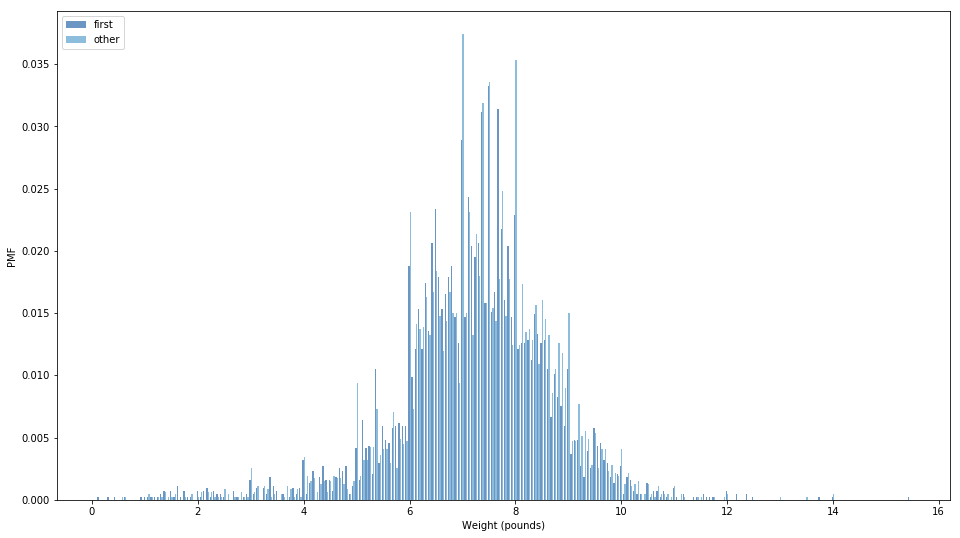

In [128]:
width = 0.4 / 16

plt.figure(figsize=(16,9))

# plot PMFs of birth weights for first babies and others
thinkplot.PrePlot(2)
thinkplot.Hist(first_pmf, align='right', width=width)
thinkplot.Hist(other_pmf, align='left', width=width)
thinkplot.Config(xlabel='Weight (pounds)', ylabel='PMF')

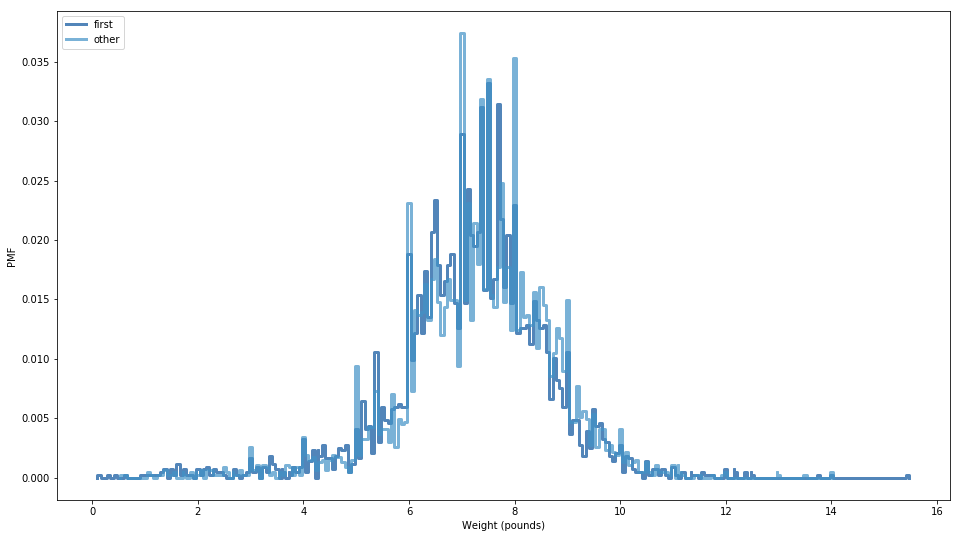

In [129]:
plt.figure(figsize=(16,9))

# plot PMFs of birth weights for first babies and others
thinkplot.PrePlot(2)
thinkplot.Pmf(first_pmf)
thinkplot.Pmf(other_pmf)
thinkplot.Config(xlabel='Weight (pounds)', ylabel='PMF')

Overall, these distributions resemble the bell shape of a normal distribution, with many values near the mean and a few values much higher and lower.

But parts of this figure are hard to interpret. There are many spikes and valleys, and some apparent differences between the distributions. It is hard to tell which of these features are meaningful. Also, it is hard to see overall patterns; for example, which distribution do you think has the higher mean?

These problems can be mitigated by binning the data; that is, dividing the range of values into non-overlapping intervals and counting the number of values in each bin. Binning can be useful, but it is tricky to get the size of the bins right. If they are big enough to smooth out noise, they might also smooth out useful information.

An alternative that avoids these problems is the **cumulative distribution function** (CDF). But before we can explain CDFs, we have to explain percentiles.

# Percentiles
If you have taken a standardized test, you probably got your results in the form of a raw score and a percentile rank. In this context, the percentile rank is the fraction of people who scored lower than you (or the same). So if you are “in the 90th percentile,” you did as well as or better than 90% of the people who took the exam.

Here’s how you could compute the percentile rank of a value, `your_score`, relative to the values in the sequence scores.

`PercentileRank` computes the fraction of `scores` less than or equal to `your_score`.

In [130]:
def PercentileRank(scores, your_score):
    count = 0
    for score in scores:
        if score <= your_score:
            count += 1

    percentile_rank = 100.0 * count / len(scores)
    return percentile_rank

If this is the list of scores.

In [131]:
t = [55, 66, 77, 88, 99]

And you got the 88, your percentile rank is 80.

In [132]:
PercentileRank(t, 88)

80.0

As an example, if the scores in the sequence were 55, 66, 77, 88 and 99, and you got the 88, then your percentile rank would be 100 * 4 / 5 which is 80.

If you are given a value, it is easy to find its percentile rank; going the other way is slightly harder. If you are given a percentile rank and you want to find the corresponding value, one option is to sort the values and search for the one you want:

`Percentile` takes a percentile rank and computes the corresponding percentile. 

In [133]:
def Percentile(scores, percentile_rank):
    scores.sort()
    for score in scores:
        if PercentileRank(scores, score) >= percentile_rank:
            return score

The median is the 50th percentile, which is 77.

In [134]:
Percentile(t, 50)

77

The result of this calculation is a percentile. For example, the 50th percentile is the value with percentile rank 50. In the distribution of exam scores, the 50th percentile is 77.

This implementation of `Percentile` is not efficient. A better approach is to use the percentile rank to compute the index of the corresponding percentile.

Here's a more efficient way to compute percentiles.

In [135]:
def Percentile2(scores, percentile_rank):
    scores.sort()
    # // Divides and returns the integer value of the quotient. It dumps the digits after the decimal.
    index = percentile_rank * (len(scores)-1) // 100
    return scores[index]

Let's hope we get the same answer.

In [136]:
Percentile2(t, 50)

77

The difference between “percentile” and “percentile rank” can be confusing, and people do not always use the terms precisely.

To summarize, `PercentileRank` takes a value and computes its percentile rank in a set of values; `Percentile` takes a percentile rank and computes the corresponding value.

# CDFs
Now that we understand percentiles and percentile ranks, we are ready to tackle the *cumulative distribution function* (CDF). The CDF is the function that **maps from a value to its percentile rank**.

The CDF is a function of $x$, where $x$ is any value that might appear in the distribution. To evaluate $CDF(x)$ for a particular value of $x$, we compute the fraction of values in the distribution less than or equal to $x$.

The Cumulative Distribution Function (CDF) is almost the same as `PercentileRank`.  The only difference is that the result is 0-1 instead of 0-100.

Here’s what that looks like as a function that takes a sequence, t, and a value, x:

In [137]:
def EvalCdf(sample, x):
    count = 0.0
    for value in sample:
        if value <= x:
            count += 1

    prob = count / len(sample)
    return prob

As an example, suppose we collect a sample with the values [1, 2, 2, 3, 5].

In [138]:
t = [1, 2, 2, 3, 5]

Here are some values from its CDF:

In [139]:
EvalCdf(t, 0), EvalCdf(t, 1), EvalCdf(t, 2), EvalCdf(t, 3), EvalCdf(t, 4), EvalCdf(t, 5)

(0.0, 0.2, 0.6, 0.8, 0.8, 1.0)

We can evaluate the CDF for any value of x, not just values that appear in the sample. If x is less than the smallest value in the sample, CDF(x) is 0. If x is greater than the largest value, CDF(x) is 1.

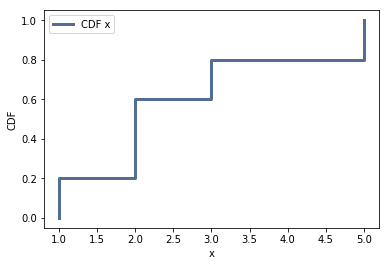

In [140]:
cdf = thinkstats2.Cdf(t, label='CDF x')
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='x', ylabel='CDF', loc='upper left')

# Representing CDFs
`thinkstats2` provides a class named `Cdf` that represents CDFs. The fundamental methods `Cdf` provides are:

* **Prob(x)**: <br>
Given a value x, computes the probability p = CDF(x). The bracket operator is equivalent to Prob.

* **Value(p)**:<br>
Given a probability p, computes the corresponding value, x; that is, the **inverse CDF** of p.

The Cdf constructor can take as an argument a list of values, a pandas Series, a Hist, Pmf, or another Cdf. The following code makes a Cdf for the distribution of pregnancy lengths in the NSFG:

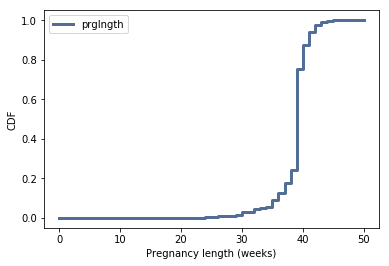

In [141]:
cdf = thinkstats2.Cdf(live.prglngth, label='prglngth')
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Pregnancy length (weeks)', ylabel='CDF', loc='upper left')

One way to read a CDF is to look up percentiles. `Cdf` provides `Prob`, which evaluates the CDF; that is, it computes the fraction of values less than or equal to the given value. 

For example, it looks like about 12.5% of pregnancies are shorter than 36 weeks

In [142]:
cdf.Prob(36)

0.12538259728902493

For example, 94% of pregnancy lengths are less than or equal to 41.

In [143]:
cdf.Prob(41)

0.9406427634455619

`Value` evaluates the inverse CDF; given a fraction, it computes the corresponding value.  For example, the median is the value that corresponds to 0.5.

In [144]:
cdf.Value(0.5)

39

The CDF also provides a visual representation of the shape of the distribution. Common values appear as steep or vertical sections of the CDF; in this example, the mode at 39 weeks is apparent.

There are few values below 30 weeks, so the CDF in this range is flat.

It takes some time to get used to CDFs, but once you do, we think you will find that they show more information, more clearly, than PMFs.

# Comparing CDFs
CDFs are especially useful for comparing distributions. In general, CDFs are a good way to visualize distributions. They are not as noisy as PMFs, and if you plot several CDFs on the same axes, any differences between them are apparent.

For example, here is the code that plots the CDF of birth weights for first babies and others.

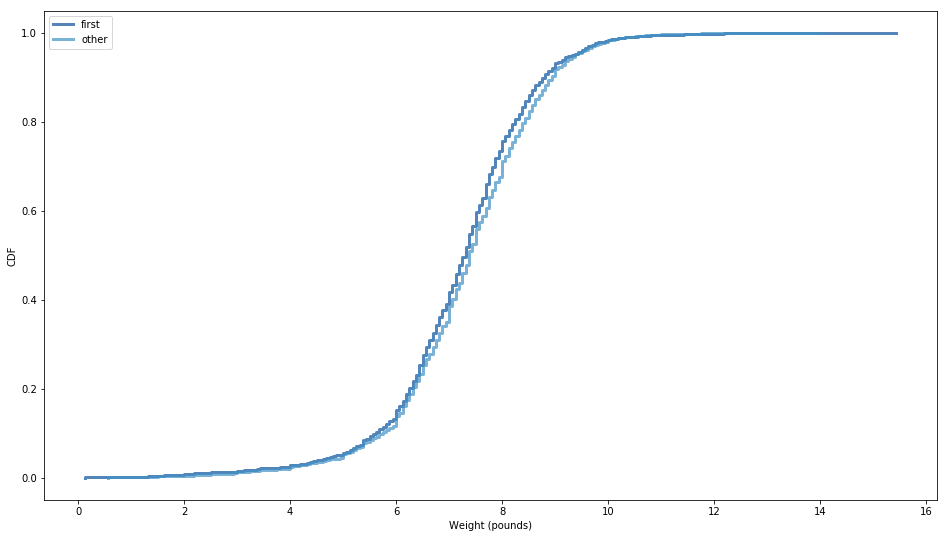

In [145]:
plt.figure(figsize=(16,9))

first_cdf = thinkstats2.Cdf(firsts.totalwgt_lb, label='first')
other_cdf = thinkstats2.Cdf(others.totalwgt_lb, label='other')

thinkplot.PrePlot(2)
thinkplot.Cdfs([first_cdf, other_cdf])
thinkplot.Config(xlabel='Weight (pounds)', ylabel='CDF')

Compared to PMF, this figure makes the shape of the distributions, and the differences between them, much clearer.

We can see that first babies are slightly lighter throughout the distribution, with a larger discrepancy above the mean.

# Percentile-Based Statistics
Once you have computed a CDF, it is easy to compute percentiles and percentile ranks.

The Cdf class provides these two methods:

* **PercentileRank(x)**:(Same is Prob, but returns probability * 100)<br>
Given a value x, computes its percentile rank, 100 · CDF(x).

* **Percentile(p)**:(Same as Value, but takes percentile rank instead of probabilities)<br>
Given a percentile rank rank, computes the corresponding value, x. Equivalent to Value(p/100).

Percentile can be used to compute percentile-based summary statistics. For example, the 50th percentile is the value that divides the distribution in half, also known as the **median**. Like the mean, the median is a measure of the central tendency of a distribution.

Actually, there are several definitions of “median,” each with different properties. But Percentile(50) is simple and efficient to compute.

Another percentile-based statistic is the **interquartile range (IQR)**, which is a measure of the spread of a distribution. The IQR is the difference between the 75th and 25th percentiles.

More generally, percentiles are often used to summarize the shape of a distribution. For example, the distribution of income is often reported in “quintiles”; that is, it is split at the 20th, 40th, 60th and 80th percentiles.

Other distributions are divided into 10 “deciles”.

Statistics like these that represent equally spaced points in a CDF are called **quantiles**.

We can use the CDF of birth weight to compute percentile-based statistics.

In [146]:
weights = live.totalwgt_lb
live_cdf = thinkstats2.Cdf(weights, label='live')

Again, the median is the 50th percentile.

In [147]:
median = live_cdf.Percentile(50)
median

7.375

In [148]:
live_cdf.Value(0.5)

7.375

The interquartile range is the interval from the 25th to 75th percentile.

In [149]:
iqr = (live_cdf.Percentile(25), live_cdf.Percentile(75))
iqr

(6.5, 8.125)

We can use the CDF to look up the percentile rank of a particular value.  For example, my second daughter was 10.2 pounds at birth, which is near the 99th percentile.

In [150]:
live_cdf.PercentileRank(10.2)

98.82717415357381

In [151]:
live_cdf.Prob(10.2)

0.988271741535738

## Exercises

**Exercise:** How much did you weigh at birth? If you don’t know, call your mother or someone else who knows. Using the NSFG data (all live births), compute the distribution of birth weights and use it to find your percentile rank. If you were a first baby, find your percentile rank in the distribution for first babies. Otherwise use the distribution for others. If you are in the 90th percentile or higher, call your mother back and apologize.

In [ ]:
# Solution

**Exercise:** The numbers generated by `numpy.random.random` are supposed to be uniform between 0 and 1; that is, every value in the range should have the same probability.

Generate 1000 numbers from `numpy.random.random` and plot their PMF.  What goes wrong?

Now plot the CDF. Is the distribution uniform?

In [79]:
# Solution

